In [ ]:
# Cell 1: Install (optional) and imports
# Run this first. Most packages are preinstalled in Colab.
!pip install -q scikit-learn   # safe to run even if already installed

import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
%matplotlib inline


In [ ]:
# Cell 2: Upload CSV from your computer (recommended) OR Colab's /content if already present.
# After running, this cell will either load the uploaded CSV or a CSV file found in /content.

print("Step: upload your CSV now using the file chooser that will appear (or skip if file already in /content).")
uploaded = files.upload()  # choose the file you downloaded from Kaggle (e.g., crop_yield.csv)

# Find CSV file (uploaded or already in /content)
csv_files = [name for name in uploaded.keys() if name.lower().endswith('.csv')]
if not csv_files:
    # check working dir
    csv_files = [f for f in os.listdir('.') if f.lower().endswith('.csv')]

if not csv_files:
    raise FileNotFoundError("No CSV file found. Upload the dataset (Download from Kaggle first), or place it in the Colab /content directory.")
else:
    print("Found CSV(s):", csv_files)
    # pick the first CSV by default
    filename = csv_files[0]
    print("Loading:", filename)
    if filename in uploaded:
        df = pd.read_csv(io.BytesIO(uploaded[filename]), low_memory=False)
    else:
        df = pd.read_csv(filename, low_memory=False)
    print("Loaded. Shape:", df.shape)

Step: upload your CSV now using the file chooser that will appear (or skip if file already in /content).


Saving crop_yeild_dataset.csv to crop_yeild_dataset (2).csv
Found CSV(s): ['crop_yeild_dataset (2).csv']
Loading: crop_yeild_dataset (2).csv
Loaded. Shape: (250000, 11)


In [ ]:
# Cell 3: quick inspection and robust numeric coercion
print("Columns and dtypes (first view):")
display(df.head())
print("\nData shape:", df.shape)
print("\nDtypes:")
print(df.dtypes)

# Count missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Create a numeric-only dataframe for outlier detection that coerces numeric-like strings to numbers
def make_numeric_df(orig_df):
    # convert strings with commas like "1,234" -> 1234
    numeric_df = orig_df.apply(lambda s: pd.to_numeric(s.astype(str).str.replace(',','').str.strip(), errors='coerce'))
    return numeric_df

numeric_df = make_numeric_df(df)
numeric_cols = [c for c in numeric_df.columns if numeric_df[c].notna().sum() > 0]
print("\nDetected numeric-ish columns (will be used for outlier checks):")
print(numeric_cols)

# show basic stats for numeric columns
if numeric_cols:
    display(numeric_df[numeric_cols].describe().T)
else:
    print("No numeric columns detected. Check your CSV or column parsing.")

Columns and dtypes (first view):


,crop,region,N,P,K,temperature,humidity,rainfall,ph,area_ha,production_t
0,rice,Karnataka,70.7,43.6,54.9,27.2,61.2,255.9,6.95,268,928.2
1,rice,Punjab,108.8,46.9,43.4,25.5,58.7,87.0,7.08,605,2213.1
2,maize,West Bengal,91.9,34.7,30.4,27.5,73.5,349.9,5.99,410,2409.2
3,rice,Maharashtra,120.0,51.6,64.3,30.4,44.2,3.7,7.20,986,2303.9
4,sugarcane,Maharashtra,164.8,57.0,173.0,24.0,39.5,43.0,6.81,941,77299.3



Data shape: (250000, 11)

Dtypes:
crop             object
region           object
N               float64
P               float64
K               float64
temperature     float64
humidity        float64
rainfall        float64
ph              float64
area_ha           int64
production_t    float64
dtype: object

Missing values per column:
crop            0
region          0
N               0
P               0
K               0
temperature     0
humidity        0
rainfall        0
ph              0
area_ha         0
production_t    0
dtype: int64

Detected numeric-ish columns (will be used for outlier checks):
['N', 'P', 'K', 'temperature', 'humidity', 'rainfall', 'ph', 'area_ha', 'production_t']


,count,mean,std,min,25%,50%,75%,max
N,250000.0,107.971981,30.380535,25.5,84.80,101.4,126.30,200.0
P,250000.0,47.177051,15.931829,10.0,35.60,44.5,56.70,80.0
K,250000.0,79.138759,63.180215,20.0,40.70,52.5,73.90,250.0
temperature,250000.0,29.796679,4.097005,10.6,27.00,29.6,32.30,45.0
humidity,250000.0,62.014827,13.852868,10.0,53.30,62.9,71.90,100.0
rainfall,250000.0,123.828643,98.480983,0.0,46.40,106.7,182.10,500.0
ph,250000.0,6.739978,0.713060,4.0,6.21,6.8,7.31,9.0
area_ha,250000.0,500.047020,288.377456,1.0,250.00,500.0,749.00,1000.0
production_t,250000.0,9306.363190,18787.908711,1.0,802.80,1693.2,3535.00,110962.3


In [ ]:
# Cell 4: helper functions (IQR, Z-score) and a summary function
import math
from scipy import stats  # SciPy present in Colab; used for z-score

def iqr_bounds(series, k=1.5):
    # series should be numeric with NaNs allowed
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

def detect_outliers_iqr(series, k=1.5):
    lower, upper = iqr_bounds(series, k=k)
    return (series < lower) | (series > upper)

def detect_outliers_zscore(series, thresh=3.0):
    if series.dropna().shape[0] == 0:
        return pd.Series(False, index=series.index)
    std = series.std(ddof=0)
    if std == 0 or math.isnan(std):
        # constant series -> no z-score outliers
        return pd.Series(False, index=series.index)
    z = (series - series.mean()) / std
    return z.abs() > thresh

def outlier_summary(df_numeric, method='iqr', k=1.5, z_thresh=3.0):
    # returns dict: {col: number_of_outliers}
    out_counts = {}
    for c in df_numeric.columns:
        s = df_numeric[c]
        if s.dropna().shape[0] == 0:
            out_counts[c] = 0
            continue
        if method == 'iqr':
            mask = detect_outliers_iqr(s, k=k)
        elif method == 'z':
            mask = detect_outliers_zscore(s, thresh=z_thresh)
        else:
            raise ValueError("method must be 'iqr' or 'z'")
        out_counts[c] = int(mask.sum())
    return out_counts

In [ ]:
# Cell 5: show IQR and Z-counts for each numeric column
if not numeric_cols:
    print("No numeric columns to analyze.")
else:
    iqr_counts = outlier_summary(numeric_df[numeric_cols], method='iqr', k=1.5)
    z_counts   = outlier_summary(numeric_df[numeric_cols], method='z', z_thresh=3.0)

    summary_df = pd.DataFrame({
        'iqr_outliers': pd.Series(iqr_counts),
        'z_outliers': pd.Series(z_counts),
        'non_nulls': numeric_df[numeric_cols].notna().sum()
    })
    display(summary_df.sort_values('iqr_outliers', ascending=False))

,iqr_outliers,z_outliers,non_nulls
K,50072,0,250000
production_t,45447,8637,250000
temperature,3709,1490,250000
rainfall,3382,1529,250000
N,3114,1237,250000
humidity,2746,1256,250000
ph,129,170,250000
P,0,0,250000
area_ha,0,0,250000


from matplotlib import pyplot as plt
_df_0['iqr_outliers'].plot(kind='hist', bins=20, title='iqr_outliers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['z_outliers'].plot(kind='hist', bins=20, title='z_outliers')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='iqr_outliers', y='z_outliers', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['non_nulls']
  ys = series['iqr_outliers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('non_nulls', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('non_nulls')
_ = plt.ylabel('iqr_outliers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['non_nulls']
  ys = series['z_outliers']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('non_nulls', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('non_nulls')
_ = plt.ylabel('z_outliers')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['non_nulls']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'non_nulls'}, axis=1)
              .sort_values('non_nulls', ascending=True))
  xs = counted['non_nulls']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('non_nulls', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('non_nulls')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['iqr_outliers'].plot(kind='line', figsize=(8, 4), title='iqr_outliers')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['z_outliers'].plot(kind='line', figsize=(8, 4), title='z_outliers')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# Cell 6: Remove rows that are outliers in ANY selected numeric column (IQR method).
# This is the simplest, most explainable approach.
# You can change `cols_to_check` or use other method (zscore, isolation forest below).

cols_to_check = numeric_cols  # set a subset if you prefer, e.g. ['production','rainfall']
k = 1.5      # IQR factor; larger -> keep more points; smaller -> remove more
how = 'any'  # 'any' = remove if a row is outlier in any column; 'all' = remove if outlier in all columns

def remove_outliers_iqr(df_orig, df_numeric, cols=None, k=1.5, how='any'):
    if cols is None:
        cols = df_numeric.columns.tolist()
    if how not in ('any','all'):
        raise ValueError("how must be 'any' or 'all'")
    masks = []
    for c in cols:
        s = df_numeric[c]
        lower, upper = iqr_bounds(s, k=k)
        mask = (s < lower) | (s > upper)
        masks.append(mask.fillna(False))
    if not masks:
        return df_orig.copy(), 0
    if how == 'any':
        combined = pd.concat(masks, axis=1).any(axis=1)
    else:
        combined = pd.concat(masks, axis=1).all(axis=1)
    removed_count = int(combined.sum())
    df_cleaned = df_orig.loc[~combined].copy()
    return df_cleaned, removed_count

df_iqr_clean, removed_iqr = remove_outliers_iqr(df, numeric_df, cols=cols_to_check, k=k, how=how)
print(f"IQR removal ('{how}', k={k}): removed {removed_iqr} rows. New shape: {df_iqr_clean.shape} (old: {df.shape})")

IQR removal ('any', k=1.5): removed 58158 rows. New shape: (191842, 11) (old: (250000, 11))


In [ ]:
# Cell 7: Use IsolationForest for multivariate outlier detection (advanced).
# It considers all numeric features together instead of column-by-column.
# We impute missing numeric values with medians before model.

from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

contamination = 0.01   # estimated fraction of outliers (adjust: 0.01 = 1%)
if not numeric_cols:
    print("No numeric columns for isolation forest.")
else:
    X = numeric_df[numeric_cols]  # numeric_df is aligned with original df index
    imputer = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

    iso = IsolationForest(contamination=contamination, random_state=42)
    iso.fit(X_imp)
    preds = iso.predict(X_imp)   # -1 = outlier, 1 = inlier
    outlier_index = X_imp.index[preds == -1]
    print("IsolationForest found", len(outlier_index), "outliers with contamination=", contamination)

    # create cleaned df
    df_iforest_clean = df.drop(index=outlier_index)
    print("Iforest cleaned shape:", df_iforest_clean.shape)

IsolationForest found 2500 outliers with contamination= 0.01
Iforest cleaned shape: (247500, 11)


In [ ]:
# Cell 8: LOF (Local Outlier Factor) - unsupervised neighbor-based method.
from sklearn.neighbors import LocalOutlierFactor

lof_contamination = 0.01
if numeric_cols:
    X = numeric_df[numeric_cols]
    imp = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    lof = LocalOutlierFactor(n_neighbors=20, contamination=lof_contamination)
    y_pred = lof.fit_predict(X_imp)   # -1 outlier, 1 inlier
    lof_out_idx = X_imp.index[y_pred == -1]
    print("LOF found", len(lof_out_idx), "outliers with contamination=", lof_contamination)
    df_lof_clean = df.drop(index=lof_out_idx)
    print("LOF cleaned shape:", df_lof_clean.shape)
else:
    print("No numeric columns for LOF.")

LOF found 2500 outliers with contamination= 0.01
LOF cleaned shape: (247500, 11)


Plotting: N


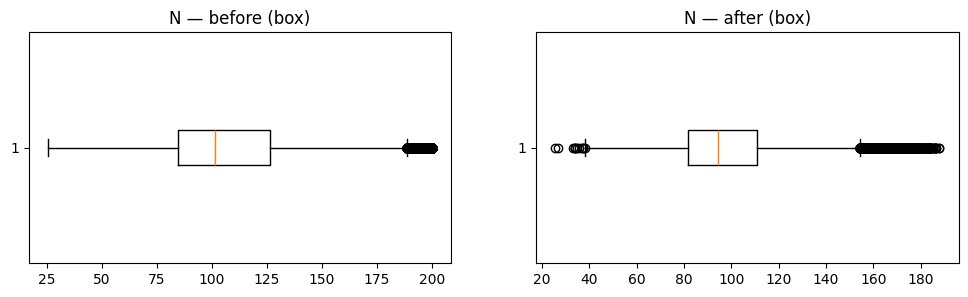

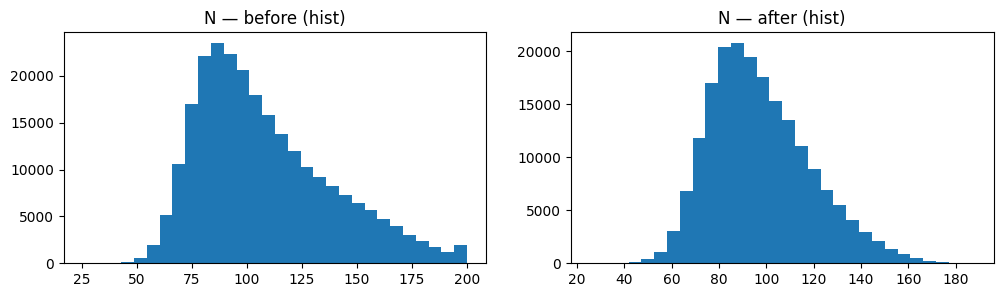

Plotting: P


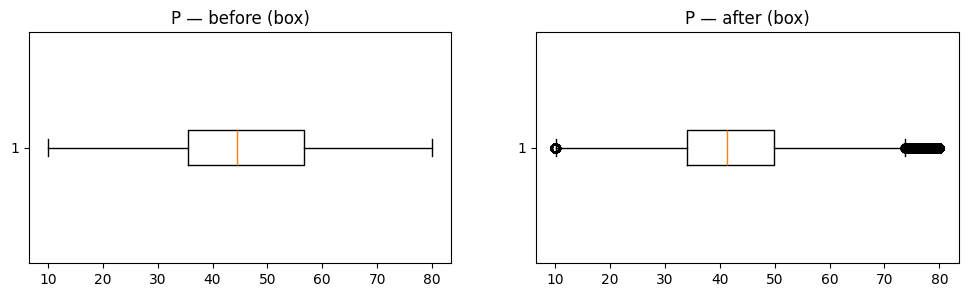

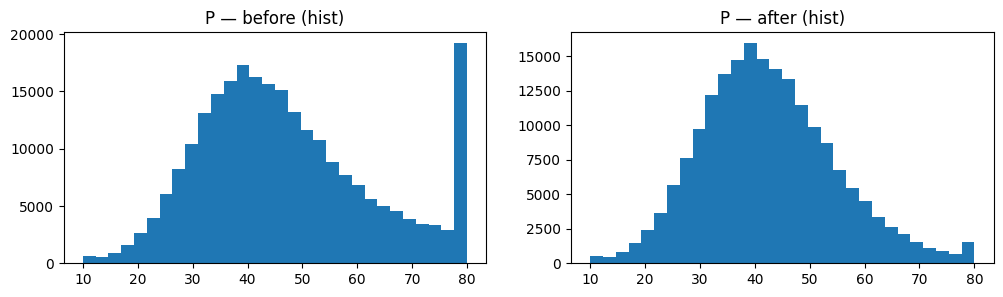

Plotting: K


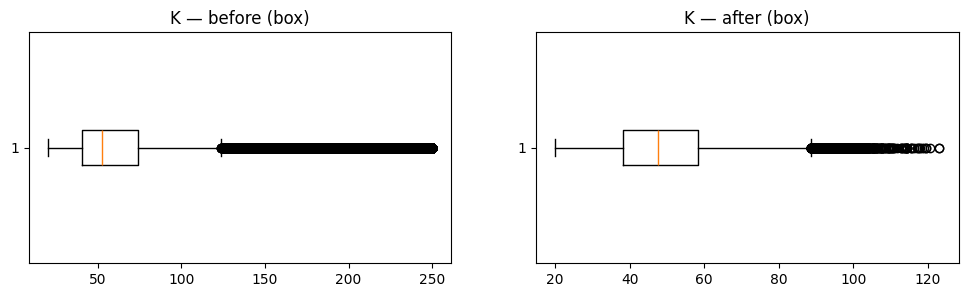

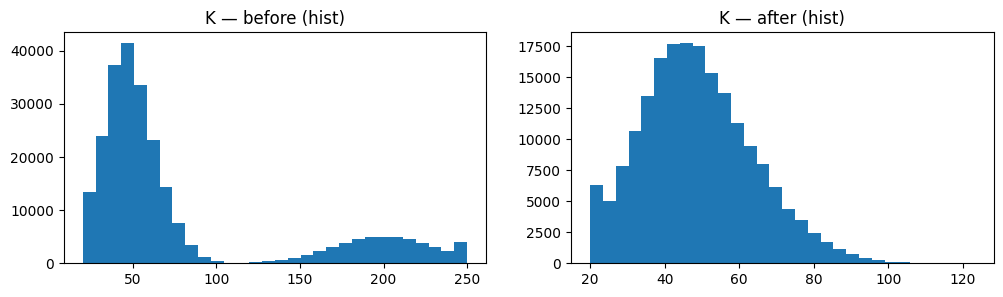

Plotting: temperature


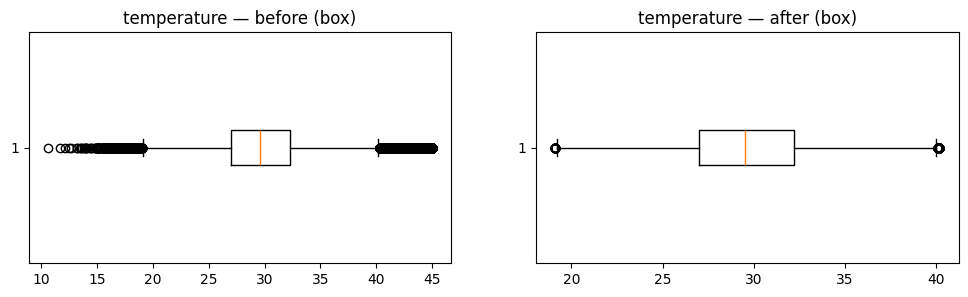

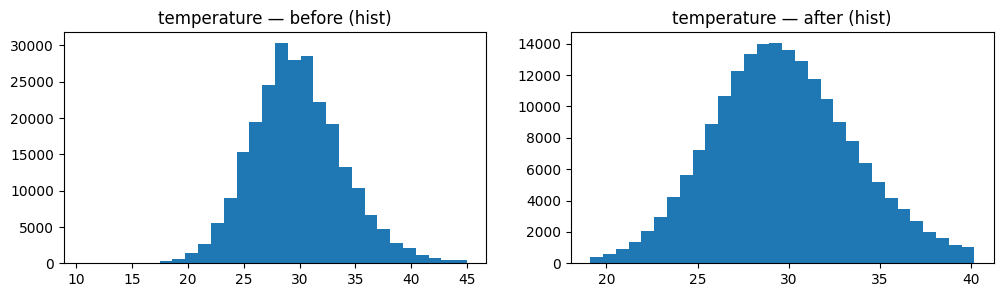

Plotting: humidity


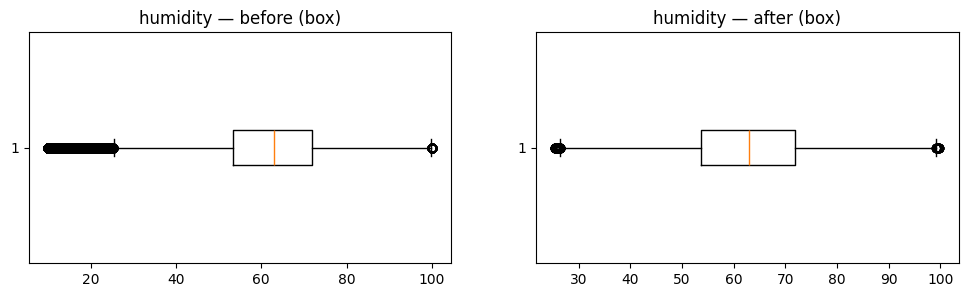

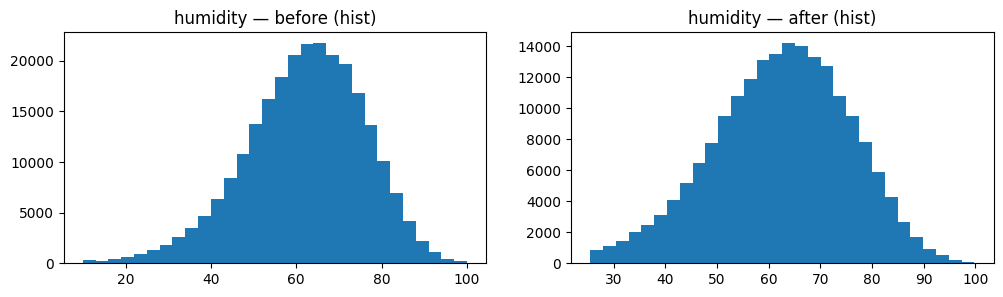

Plotting: rainfall


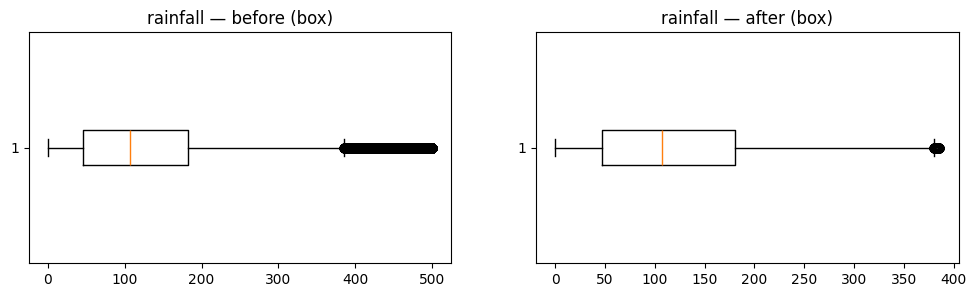

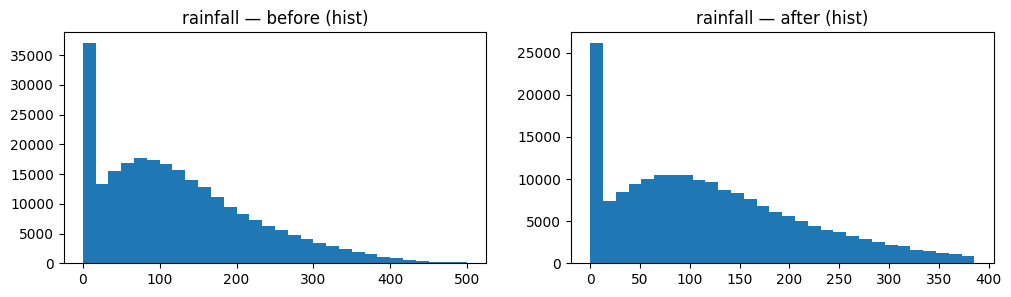

In [ ]:
# Cell 9: Boxplots & histograms for a few important numeric columns before and after IQR removal.
cols_plot = cols_to_check[:6]  # up to first 6 numeric columns

def plot_box_hist(series_before, series_after, col_name):
    plt.figure(figsize=(12,3))
    # boxplots
    plt.subplot(1,2,1)
    plt.boxplot(series_before.dropna(), vert=False)
    plt.title(f"{col_name} — before (box)")
    plt.subplot(1,2,2)
    plt.boxplot(series_after.dropna(), vert=False)
    plt.title(f"{col_name} — after (box)")
    plt.show()
    # histograms
    plt.figure(figsize=(12,3))
    plt.subplot(1,2,1)
    plt.hist(series_before.dropna(), bins=30)
    plt.title(f"{col_name} — before (hist)")
    plt.subplot(1,2,2)
    plt.hist(series_after.dropna(), bins=30)
    plt.title(f"{col_name} — after (hist)")
    plt.show()

for c in cols_plot:
    before = numeric_df[c]
    after = make_numeric_df(df_iqr_clean)[c] if c in make_numeric_df(df_iqr_clean).columns else pd.Series(dtype=float)
    print("Plotting:", c)
    plot_box_hist(before, after, c)

In [ ]:
# Cell 10: Save whichever cleaned DataFrame you want to keep.
# Examples:
#   df_iqr_clean      -> cleaned by univariate IQR (Cell 6)
#   df_iforest_clean  -> cleaned by IsolationForest (Cell 7)
#   df_lof_clean      -> cleaned by LOF (Cell 8)

# Choose one:
df_cleaned = df_iqr_clean   # change to df_iforest_clean or df_lof_clean if you prefer

outname = "crop_yield_cleaned.csv"
df_cleaned.to_csv(outname, index=False)
print("Saved cleaned file to:", outname)

# Offer download to your machine:
files.download(outname)   # triggers browser download in Colab

# OR: save to Google Drive (uncomment to use)
# from google.colab import drive
# drive.mount('/content/drive')
# df_cleaned.to_csv('/content/drive/MyDrive/' + outname, index=False)
# print("Saved to Google Drive: /content/drive/MyDrive/" + outname)


Saved cleaned file to: crop_yield_cleaned.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>